In [30]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from matplotlib.colors import LogNorm

from driven_nickelate.config import paths as PROJECT_PATHS

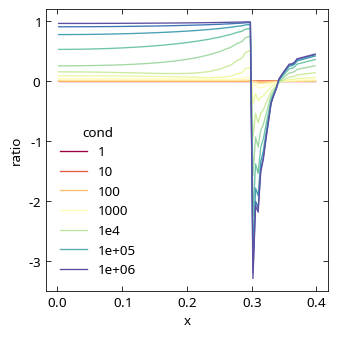

In [65]:
data = (
    pl.read_csv(
        PROJECT_PATHS.root / "simulations/data/26.02.24/xcond_gapcut.csv",
        comment_prefix="%",
    )
    .select(pl.col("x"), pl.col("^.*Ey.*$"))
    .unpivot(index="x", value_name="Ey")
    .with_columns(
        pl.col("variable").str.split("=").list[1].cast(pl.Float64).alias("cond")
    )
)

data = data.join(
    data.filter(pl.col("cond").eq(pl.col("cond").min())).select("x", "Ey"),
    on="x",
    suffix="_ref",
).with_columns((1 - pl.col("Ey") / pl.col("Ey_ref")).alias("ratio"))

cond_norm = LogNorm(vmin=data["cond"].min(), vmax=data["cond"].max())
g = sns.lineplot(
    data, x="x", y="ratio", hue="cond", hue_norm=cond_norm, palette="Spectral"
)

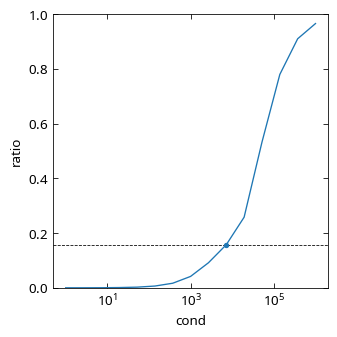

In [82]:
fig, ax = plt.subplots()

sns.lineplot(
    data.filter(pl.col("x").eq(pl.col("x").min())), x="cond", y="ratio", ax=ax
).set(xscale="log", ylim=(0, 1))

x, r = (
    data.filter(pl.col("x").eq(pl.col("x").min()))
    .with_columns((pl.col("cond") - 6e3).abs().alias("diff"))
    .filter(pl.col("diff") == pl.col("diff").min())
    .select("cond", "ratio")
)
ax.scatter(x, r)
ax.axhline(r.item(), color="black", linestyle="--", zorder=-1, lw=0.6)